# Multi-class classification on Stack Overflow questions.

In [1]:
# https://www.tensorflow.org/tutorials/keras/text_classification

import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from pathlib import Path
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
print(tf.__version__)

2.6.0


In [2]:
# Sentiment analysis. (Download and extract the dataset)
"""This notebook trains a sentiment analysis model to classify movie reviews as positive or negative, 
based on the text of the review"""

https_url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"
http_url = "http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"
try:
    dataset = tf.keras.utils.get_file("stack_overflow_16k.tar.gz", https_url,
                                        untar=True, cache_dir='.',
                                        cache_subdir='')
except:
    dataset = tf.keras.utils.get_file("stack_overflow_16k.tar.gz", http_url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')
dataset_dir = Path(dataset).parent

6062080/6053168 [==============================] - 1s 0us/step


In [3]:
# Directory structure.
os.listdir(dataset_dir)

['test',
 'stack_overflow_16k.tar.gz',
 'README.md',
 'train',
 '.ipynb_checkpoints',
 'stackoverflow.ipynb']

In [4]:
# Move train/test folder.
os.mkdir("stackoverflow")
shutil.move("test", "stackoverflow/test")
shutil.move("train", "stackoverflow/train")

'stackoverflow/train'

In [5]:
# Train dir.
train_dir = os.path.join(dataset_dir, 'stackoverflow/train')
os.listdir(train_dir)

['python', 'java', 'csharp', 'javascript']

In [6]:
# Directories contain many text files, each of which is a single stackoverflow programming question.
sample_file = os.path.join(train_dir, 'python/999.txt')
with open(sample_file) as f:
    print(f.read())

"else command not running correctly? (blank 3 beginner) i'm working on a combo menu for my first blank program. i've gotten everything to work properly up to this point. i want the program to exit if the user's input isn't equal to the accepted answers. i've tried a few different methods to get this working, but it still just runs like i answered ""yes"" or ""yes"". any help? thanks a ton. ..here is my code: ..def p(): #prints new line quiokly.    print()..def error(): #restarts the main.    question = input(""you have entered an invalid option. would you like to try your order again? n"").    if question in (""yes"",""yes"",""yes""):.        main().    else:.        exit..def main(): #main block of code.    cost = 0 #total cost variable.    if cost == 0:.        print(""what type of sandwhich would you like? refer to the cost and type of sandwhich below."").        p().        print(""chicken sandwhich = $5.25"").        p().        print(""tofu sandwhich = $5.75"").        p().      

In [7]:
# Create a validation set. (80:20)
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'stackoverflow/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


2021-08-12 23:12:11.524299: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# If you're new to tf.data, you can also iterate over the dataset and print out a few examples as follows.
# The labels are 0 or 1. 
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])
        print("\n")

2021-08-12 23:12:11.743978: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Review b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default constru

In [9]:
# To see which of these correspond to positive and negative movie reviews, 
# you can check the class_names property on the dataset.
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [10]:
# Next, you will create a validation and test dataset. You will use the remaining 5,000 
# reviews from the training set for validation.
# Validation.
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'stackoverflow/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [11]:
# Test.
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'stackoverflow/test', 
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [12]:
# Next, you will standardize, tokenize, and vectorize the data using the helpful preprocessing.
# TextVectorization layer.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [13]:
# Next, you will create a TextVectorization layer.
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [14]:
# Next, you will call adapt to fit the state of the preprocessing layer to the dataset. 
# This will cause the model to build an index of strings to integers.
# Make a text-only dataset (without labels), then call adapt.
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [15]:
# Let's create a function to see the result of using this layer to preprocess some data.
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [16]:
# Retrieve a batch (of 32 stackoverflow programming question and labels) from the dataset.
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"set blank to quit on exception? i\'m using blank 3..i\'ve been looking around for an answer to this, but i haven\'t found it yet. basically, i\'m running several blank scripts into a game engine, and each script has its own entry point...i\'d rather not add try: except blocks through all of my code, so i was wondering if it\'s at all possible to tell blank to quit (or perhaps assign a custom function to that ""callback"") on finding its first error, regardless of where or what it found? ..currently, the game engine will continue after finding and hitting an error, making it more difficult than necessary to diagnose issues since running into one error may make a subsequent script not work (as it relies on variables that the error-ing script set, for example). any ideas? ..i know that i could redirect the console to a file to allow for easier scrolling, but just capturing the first error and stopping the game prematurely would be really useful...okay, a couple of extr

In [17]:
# As you can see above, each token has been replaced by an integer. 
# You can lookup the token (string) that
# each integer corresponds to by calling .get_vocabulary() on the layer.
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  scissors
 313 --->  source
Vocabulary size: 10000


In [18]:
# You are nearly ready to train your model. As a final preprocessing step, you will apply
# the TextVectorization layer you created earlier to the train, validation, and test dataset.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [19]:
# Example.
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
# Create a neural network.
embedding_dim = 16
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 68        
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Configure the model to use an optimizer and a loss function.
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [22]:
# Train model.
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
200/200 [==============================] - 6s 21ms/step - loss: 1.3768 - accuracy: 0.3433 - val_loss: 1.3644 - val_accuracy: 0.4525
Epoch 2/10
200/200 [==============================] - 4s 19ms/step - loss: 1.3455 - accuracy: 0.4577 - val_loss: 1.3240 - val_accuracy: 0.5256
Epoch 3/10
200/200 [==============================] - 4s 19ms/step - loss: 1.2951 - accuracy: 0.5245 - val_loss: 1.2640 - val_accuracy: 0.5750
Epoch 4/10
200/200 [==============================] - 4s 21ms/step - loss: 1.2279 - accuracy: 0.5869 - val_loss: 1.1913 - val_accuracy: 0.6388
Epoch 5/10
200/200 [==============================] - 2s 8ms/step - loss: 1.1496 - accuracy: 0.6467 - val_loss: 1.1147 - val_accuracy: 0.6787
Epoch 6/10
200/200 [==============================] - 5s 22ms/step - loss: 1.0721 - accuracy: 0.6833 - val_loss: 1.0426 - val_accuracy: 0.6900
Epoch 7/10
200/200 [==============================] - 1s 7ms/step - loss: 1.0038 - accuracy: 0.7102 - val_loss: 0.9786 - val_accuracy: 0.7169
E

In [23]:
# Evaluate the model.
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 4s 16ms/step - loss: 0.8662 - accuracy: 0.7301
Loss:  0.8662228584289551
Accuracy:  0.7301250100135803


In [24]:
# Create a plot of accuracy and loss over time.
# model.fit() returns a History object that contains a dictionary with everything that happened during training.
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

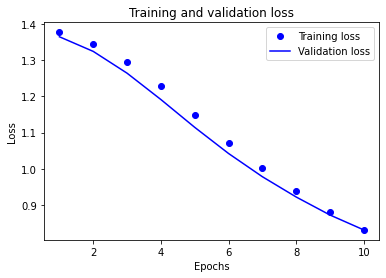

In [25]:
# There are four entries: one for each monitored metric during training and validation. 
# You can use these to plot the training and validation loss for comparison, as well as the
# training and validation accuracy.
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

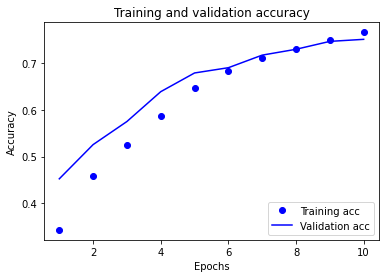

In [26]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [27]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 3s 9ms/step - loss: 0.8662 - accuracy: 0.7301
0.7301250100135803


In [28]:
examples = [
       "how do I extract keys from a dict into a list?",  # python
       "debug public static void main(string[] args) {...}",  # java
       ]

In [29]:
import numpy as np
model_result = export_model.predict(examples)

In [30]:
raw_train_ds

<BatchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int32)>

In [31]:
print(np.argmax(model_result[0]))
print(raw_train_ds.class_names[np.argmax(model_result[0])])

3
python


In [32]:
print(np.argmax(model_result[1]))
print(raw_train_ds.class_names[np.argmax(model_result[1])])

1
java


In [33]:
predicted_int_labels = tf.argmax(model_result, axis=1)
predicted_labels = tf.gather(raw_train_ds.class_names,
                               predicted_int_labels)
for example, label in zip(examples, predicted_labels):
    print("Question: ", example)
    print("Predicted label: ", label.numpy())

Question:  how do I extract keys from a dict into a list?
Predicted label:  b'python'
Question:  debug public static void main(string[] args) {...}
Predicted label:  b'java'


In [34]:
# Save model as .pb
export_model.save("stackoverflow_model")

2021-08-12 23:13:14.142257: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: stackoverflow_model/assets


In [35]:
# Save the model. (HDF5JSON)
try:
    model_json = export_model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    export_model.save_weights("model.hdf5")
except:
    pass

In [36]:
# Get TFLite from a pb model. (https://github.com/tensorflow/models/issues/8872)
converter = tf.lite.TFLiteConverter.from_saved_model("stackoverflow_model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter = True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()
open("stackoverflow.tflite","wb").write(tflite_model)

2021-08-12 23:13:17.175721: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:351] Ignored output_format.


375200

2021-08-12 23:13:17.175752: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:354] Ignored drop_control_dependency.
2021-08-12 23:13:17.175764: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored change_concat_input_ranges.
2021-08-12 23:13:17.181672: I tensorflow/cc/saved_model/reader.cc:38] Reading SavedModel from: stackoverflow_model
2021-08-12 23:13:17.197530: I tensorflow/cc/saved_model/reader.cc:90] Reading meta graph with tags { serve }
2021-08-12 23:13:17.197571: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: stackoverflow_model
2021-08-12 23:13:17.236515: I tensorflow/cc/saved_model/loader.cc:211] Restoring SavedModel bundle.
2021-08-12 23:13:17.340242: I tensorflow/cc/saved_model/loader.cc:195] Running initialization op on SavedModel bundle at path: stackoverflow_model
2021-08-12 23:13:17.587700: I tensorflow/cc/saved_model/loader.cc:283] SavedModel load for tags { serve }; Status: suc

In [37]:
# Preload model.
from tensorflow import (
    convert_to_tensor,
    lite,
)
import numpy as np
model_path="stackoverflow.tflite"
interpreter = lite.Interpreter(model_path=str(model_path), num_threads=4)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

INFO: Created TensorFlow Lite delegate for select TF ops.
INFO: TfLiteFlexDelegate delegate: 6 nodes delegated out of 33 nodes with 3 partitions.

INFO: TfLiteFlexDelegate delegate: 0 nodes delegated out of 2 nodes with 0 partitions.



In [40]:
# TFLite prediction.
result = {}
for ex in examples:
    text = np.expand_dims(np.array(ex), axis=0)
    interpreter.set_tensor(input_details[0]['index'], text)
    interpreter.invoke()
    prediction = interpreter.get_tensor(output_details[0]['index'])
    print(prediction)
    result.update({ex:[np.argmax(prediction[0]), raw_train_ds.class_names[np.argmax(prediction[0])]]})
result

[[0.5120554  0.46114618 0.4878267  0.5287277 ]]
[[0.60886675 0.6276096  0.3980441  0.40421265]]


{'how do I extract keys from a dict into a list?': [3, 'python'],
 'debug public static void main(string[] args) {...}': [1, 'java']}

array([[0.60886675, 0.6276096 , 0.3980441 , 0.40421265]], dtype=float32)

In [ ]:
examples = [
       "how do I extract keys from a dict into a list?",  # python
       "debug public static void main(string[] args) {...}",  # java
       ]